# POS Tagger Trained on the UD Treebank

Adapted from https://github.com/soutsios/pos_tagger_mlp/blob/master/pos_tagger_mlp.ipynb 

# Plot Functions

These functions are useful to visualize the training dynamics of the learning algorithm and the confusion matrix of the trained models.

In [1]:
import pyconll, nltk, datetime, warnings
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [4]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

# Preprocessing

In [5]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [6]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

Print statistics

In [7]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  12544
Tagged words in train set: 204614
Tagged sentences in dev set:  2001
Tagged words in dev set: 25151
Tagged sentences in test set:  2077
Tagged words in test set: 25096


In [8]:
print(train_sentences[0])

[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT')]


In [9]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

An important observation: how many terms are in validation set and not found in train set? (This estimates the Out-of-vocabulary rate.)

In [10]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 1662


# Feature Engineering

We use the "classical" machine learning approach: we will train a token classifier model. The classifier gets as input a feature vector describing each token in the sentence. We decide a priori which features are informative to make the tagging decision. In this case, we use a combination of "word shape" features which approximate morphological knowledge. We naturally also include lexical information (the token form itself), and some form of "syntactic knowledge" by adding reference to the previous and next word in each token feature vector.

In [11]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'word_lower': sentence[index].lower(),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1].lower(),
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1].lower(),
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In the scikit-learn model, we model a dataset as a pair of two data structures:
* The list of feature dictionaries X (one feature dictionary for each token)
* The list of predicted label y (one tag for each token)

In [12]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index)])
            y.append(tagged[index][1])
    return X, y

Given a sentence represented as a list of tokens, return the list of feature dictionaries using our feature encoding method:

In [13]:
def transform_test_sentence(sentence):
    X = []
    for index in range(len(sentence)):
            X.append([features_basic(sentence, index)])
    return X

## Test untag()

We use untag() to extract raw sentences from the annotated CoNLL dataset. This way we can reproduce a sentence without tags, submit it to the tagger and compare predictions to the gold tags that are provided in the dataset.

In [14]:
untag(test_sentences[1])

['What',
 'if',
 'Google',
 'expanded',
 'on',
 'its',
 'search',
 '-',
 'engine',
 '(',
 'and',
 'now',
 'e-mail',
 ')',
 'wares',
 'into',
 'a',
 'full',
 '-',
 'fledged',
 'operating',
 'system',
 '?']

# Dataset Transformation

Before we can apply a generic machine learning algorithm (such as Logistic Regression), we need to encode the dataset into a vectorized format.

We proceed in two steps: feature engineering and vectorization.

For each token, we create a dictionary of features that depend on the sentence from which the token is extracted. 
These features include the word itself, the word before and the word after, letter suffixes and prefixes, etc.

In the scikit-learn approach, before we can use a generic machine learning algorithm, we must then "vectorize" the feature dictionaries into vector encodings.
For example, lexical features are encoded into one-hot vectors whose dimension is the size of the vocabulary.
Note the difference between the method `fit_transform` of the vectorizer, which "learns" how to vectorize features, and `transform` which applies a learned vectorizer to feature dictionaries.  We use `fit_transform` on the training data, and `transform` on the other sections (validation and test).

These vector representations are what is passed to the machine learning algorithm.

In [15]:
def vectorize(train, val, test):

    print('Feature encoding method')
    print('Vectorizing Dataset...')
    print('Vectorizing train...')
    X_train, y_train = transform_to_dataset(train)
    v = DictVectorizer(sparse=True) 
    X_train = v.fit_transform([x[0] for x in X_train])
    
    print('Vectorizing validation...')
    X_val, y_val = transform_to_dataset(val)
    X_val = v.transform([x[0] for x in X_val])        
    
    print('Vectorizing test...')
    X_test, y_test = transform_to_dataset(test)
    X_test = v.transform([x[0] for x in X_test])
    
    print('Dataset vectorized.')
    print('Train shape:', X_train.shape)
    print('Validation shape:', X_val.shape)
    print('Test shape:', X_test.shape)
    
    # Compress sparse matrices
    X_train = X_train 
    X_val = X_val 
    X_test = X_test
    return X_train, y_train, X_val, y_val, X_test, y_test, v
    

# Baseline Tagger

Before we train a "real" machine learning algorithm using scikit-learn, we will repeat the very simple statistical method we discussed in class.
We train and evaluate the Baseline Unigram tagger to compare performance with the tagger we will train next.

In [16]:
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [17]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [18]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [19]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, zero_division=1, average='macro')))

Accuracy: 0.8670
f1-macro score: 0.7959


In [20]:
print(classification_report(y_test, y_pred, zero_division=1, digits=4))

              precision    recall  f1-score   support

         ADJ     0.9154    0.8356    0.8737      1788
         ADP     0.8697    0.8817    0.8757      2029
         ADV     0.9355    0.8044    0.8650      1191
         AUX     0.9233    0.8970    0.9099      1543
       CCONJ     0.9892    0.9973    0.9932       736
         DET     0.9612    0.9673    0.9643      1897
        INTJ     0.9655    0.6942    0.8077       121
        NOUN     0.6878    0.9323    0.7916      4123
         NUM     0.9146    0.6125    0.7337       542
        PART     0.6959    0.9769    0.8128       649
        PRON     0.9660    0.9321    0.9488      2165
       PROPN     0.9240    0.5446    0.6853      2075
       PUNCT     0.9941    0.9861    0.9901      3096
       SCONJ     0.6257    0.5964    0.6107       384
         SYM     0.7913    0.8349    0.8125       109
        VERB     0.8880    0.8243    0.8549      2606
           X     1.0000    0.0000    0.0000        42

    accuracy              

See what errors the Baseline tagger makes:

In [21]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [22]:
check_tagger(test_sentences[1])

('What', 'PRON') PRON 
('if', 'SCONJ') SCONJ 
('Google', 'PROPN') PROPN 
('expanded', 'VERB') VERB 
('on', 'ADP') ADP 
('its', 'PRON') PRON 
('search', 'NOUN') NOUN 
('-', 'PUNCT') PUNCT 
('engine', 'NOUN') NOUN 
('(', 'PUNCT') PUNCT 
('and', 'CCONJ') CCONJ 
('now', 'ADV') ADV 
('e-mail', 'NOUN') NOUN 
(')', 'PUNCT') PUNCT 
('wares', 'NOUN') NOUN 
('into', 'ADP') ADP 
('a', 'DET') DET 
('full', 'ADJ') ADV <<--- Error!
('-', 'PUNCT') PUNCT 
('fledged', 'NOUN') ADJ <<--- Error!
('operating', 'NOUN') NOUN 
('system', 'NOUN') NOUN 
('?', 'PUNCT') PUNCT 


It makes mistakes. Unsurprising given its simplistic approach and the small size of the training data.

In [23]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

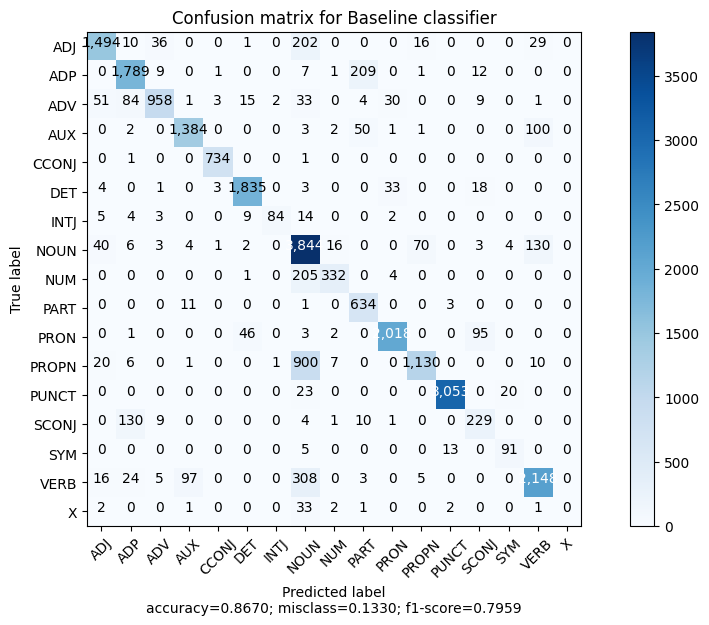

In [24]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a Logistic Regression Model

Let us move to a more serious machine learning model. We will train a Logistic Regression model using our feature extraction function based on our "expertise" in the domain.

We first transform the whole dataset from the CoNLL format into the scikit-learn vectorized encoding using our feature extraction method.

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences)

Feature encoding method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (204614, 98719)
Validation shape: (25151, 98719)
Test shape: (25096, 98719)


## Hyper-parameter Tuning

The Logistic Regression algorithm uses a hyper-parameter called C.  We tune the value of this parameter by testing different values on a subset of the training data and observing the impact of the C parameter on selected metrics (accuracy and F1).

Because we will use cross-validation, we can use the full train set (train + validation)

In [26]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [27]:
X_train.shape

(229765, 98719)

In [28]:
y_train.shape

(229765,)

In [29]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [30]:
logregr = LogisticRegression(solver='liblinear', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=4)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=4)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(random_state=13, solver='liblinear')
# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 20}

Grid scores on development set:
0.748 (+/-0.027) for {'C': 0.1}
0.828 (+/-0.046) for {'C': 1}
0.834 (+/-0.041) for {'C': 2}
0.836 (+/-0.035) for {'C': 3}
0.836 (+/-0.035) for {'C': 4}
0.838 (+/-0.029) for {'C': 5}
0.842 (+/-0.033) for {'C': 10}
0.846 (+/-0.035) for {'C': 20}
0.844 (+/-0.042) for {'C': 50}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.0000    0.0000    0.0000         1
         ADP     1.0000    0.6667    0.8000         6
         ADV     0.0000    0.0000    0.0000         4
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    0.5000    0.6667         2
         DET     0.6667    1.0000    0.8000         2
        NOUN  

## Training

We can now training using the best hyper-parameter selected above.  This takes a few minutes.

In [31]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Training...
Training completed in 266.888499 seconds


# Evaluation

In [32]:
y_pred = clf.predict(X_test)

In [33]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.9451
f1-macro score: 0.9023


## Classification Report

In [34]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

         ADJ     0.9206    0.9010    0.9107      1788
         ADP     0.9342    0.9591    0.9465      2029
         ADV     0.9225    0.8900    0.9060      1191
         AUX     0.9787    0.9825    0.9806      1543
       CCONJ     0.9946    0.9932    0.9939       736
         DET     0.9915    0.9895    0.9905      1897
        INTJ     0.9619    0.8347    0.8938       121
        NOUN     0.9044    0.9202    0.9122      4123
         NUM     0.9743    0.9797    0.9770       542
        PART     0.9799    0.9769    0.9784       649
        PRON     0.9853    0.9880    0.9866      2165
       PROPN     0.8817    0.8617    0.8716      2075
       PUNCT     0.9916    0.9958    0.9937      3096
       SCONJ     0.8567    0.8099    0.8327       384
         SYM     0.8476    0.8165    0.8318       109
        VERB     0.9440    0.9574    0.9507      2606
           X     0.5000    0.3095    0.3824        42

    accuracy              

## Frequent Types of Mistakes

In [35]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9451
Total errors/Total words: 1377/25096

Most common errors: [('that', 24), ('as', 23), ('to', 23), ('like', 22), ('/', 21), ('out', 18), ('for', 18), ('up', 18), ('in', 16), ('on', 12), ('01-Feb-02', 11), ('one', 9), ('-', 9), ('so', 8), ('much', 8), ('all', 7), ('have', 7), ('be', 7), ('of', 6), ('better', 6)]


## Learning Curves

The following diagram illustrates the "training dynamics" of the LR model: how fast does it improve as it keeps training. Originally, the difference between the test dataset and the cross-validation (on part of the test data) is large; as training proceeds, the gap reduces. This diagram is important to verify we do not have a case of over-fitting - where the model does "very well" on training data and does not improve on test data.  

This computation takes a long time (as we keep training and evaluating multiple times to obtain the snapshots). It is not necessary to run the rest of the notebook so that you can safely skip it.

In [36]:
#plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5)

## Confusion Matrix

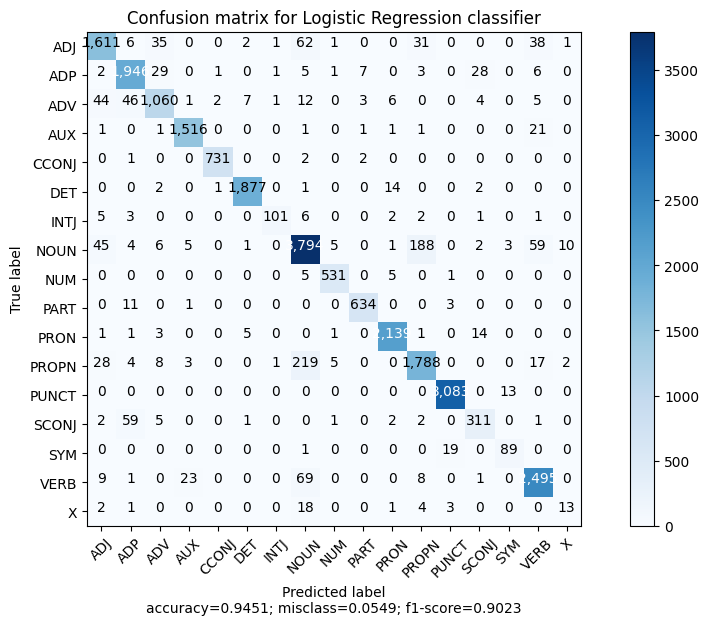

In [37]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an Unknown Sentence

Lets try our trained tagger on new sentences.  To tag a sentence given as a string, we must apply the following steps:
* Tokenize the string into a list of tokens
* Turn each token into a features dictionary (using the features used by our model)
* Turn the list of feature dictionaries into vectors (using scikit-learn vectorization method)
* Pass the resulting matrix (one row vector for each token) to the classifier.

In [38]:
# Need to download the nltk model for sentence tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\97252\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [39]:
tokens = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.')
print(tokens)

['Word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']


In [40]:
X_features = transform_test_sentence(tokens)

In [41]:
X_features

[[{'nb_terms': 13,
   'word': 'Word',
   'word_lower': 'word',
   'is_first': True,
   'is_last': False,
   'is_capitalized': True,
   'is_all_caps': False,
   'is_all_lower': False,
   'prefix-1': 'W',
   'prefix-2': 'Wo',
   'prefix-3': 'Wor',
   'suffix-1': 'd',
   'suffix-2': 'rd',
   'suffix-3': 'ord',
   'i-1_prefix-3': '',
   'i-1_suffix-3': '',
   'i+1_prefix-3': 'emb',
   'i+1_suffix-3': 'ngs',
   'prev_word': '',
   'next_word': 'embeddings',
   'has_hyphen': False,
   'is_numeric': False,
   'capitals_inside': False}],
 [{'nb_terms': 13,
   'word': 'embeddings',
   'word_lower': 'embeddings',
   'is_first': False,
   'is_last': False,
   'is_capitalized': False,
   'is_all_caps': False,
   'is_all_lower': True,
   'prefix-1': 'e',
   'prefix-2': 'em',
   'prefix-3': 'emb',
   'suffix-1': 's',
   'suffix-2': 'gs',
   'suffix-3': 'ngs',
   'i-1_prefix-3': 'Wor',
   'i-1_suffix-3': 'ord',
   'i+1_prefix-3': 'pro',
   'i+1_suffix-3': 'ide',
   'prev_word': 'word',
   'next_word'

In [42]:
X_vectorized = vec.transform([x[0] for x in X_features])

In [43]:
# The vectorized sentence is a sparse matrix with one row for each token and columns for the vectorized features
# For example, if the vocabulary has 1000 unique words, the vectorized sentence will have 1000 columns for each word feature.
# This is a very sparse matrix, where most of the values are zero.
X_vectorized.shape

(13, 98719)

In [44]:
pred = clf.predict(X_vectorized)

In [45]:
# np.str_ is a subclass of str that is used to represent string arrays in NumPy.
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(tokens, pred)))

Here is what our LR tagger predicts for the test sentence:
 [('Word', np.str_('PROPN')), ('embeddings', np.str_('NOUN')), ('provide', np.str_('VERB')), ('a', np.str_('DET')), ('dense', np.str_('ADJ')), ('representation', np.str_('NOUN')), ('of', np.str_('ADP')), ('words', np.str_('NOUN')), ('and', np.str_('CCONJ')), ('their', np.str_('PRON')), ('relative', np.str_('ADJ')), ('meanings', np.str_('NOUN')), ('.', np.str_('PUNCT'))]


Let's turn this process into a prediction function from a sentence encoded as a single string to a list of pairs (token, predicted_tag):

In [46]:
def predict_sentence(sentence):
   tokens = nltk.word_tokenize(sentence)
   X_features = transform_test_sentence(tokens)
   X_vectorized = vec.transform([x[0] for x in X_features])
   pred = clf.predict(X_vectorized)
   return list(zip(tokens, pred))

In [47]:
predict_sentence("Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.")

[('Let', np.str_('VERB')),
 ('me', np.str_('PRON')),
 ('join', np.str_('VERB')),
 ('the', np.str_('DET')),
 ('chorus', np.str_('NOUN')),
 ('of', np.str_('ADP')),
 ('annoyance', np.str_('NOUN')),
 ('over', np.str_('ADP')),
 ('Google', np.str_('PROPN')),
 ("'s", np.str_('PART')),
 ('new', np.str_('ADJ')),
 ('toolbar', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('which', np.str_('PRON')),
 (',', np.str_('PUNCT')),
 ('as', np.str_('SCONJ')),
 ('noted', np.str_('VERB')),
 ('in', np.str_('ADP')),
 ('the', np.str_('DET')),
 ('linked', np.str_('VERB')),
 ('article', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('commits', np.str_('NOUN')),
 ('just', np.str_('ADV')),
 ('about', np.str_('ADV')),
 ('every', np.str_('DET')),
 ('sin', np.str_('VERB')),
 ('an', np.str_('DET')),
 ('online', np.str_('ADJ')),
 ('marketer', np.str_('NOUN')),
 ('could', np.str_('AUX')),
 ('commit', np.str_('VERB')),
 (',', np.str_('PUNCT')),
 ('and', np.str_('CCONJ')),
 ('makes', np.str_('VERB')),
 ('up', np.str_('ADP'

# Collect Hard Sentences

Hard sentences are sentences that contain multiple wrongly predicted tags given our classifier.

Write code to collect hard sentences given a classifier clf.

## 1.2.1

In [48]:
def errors_in_sentence_prediction(clf, tagged_sentence):
    """Given a tagged sentence from the dataset, return the number of errors and the predicted tags."""
    errors = 0
    tokens = [word for word, _ in tagged_sentence] 
    true_tags = [true_tag for _, true_tag in tagged_sentence] 

    X_features = transform_test_sentence(tokens)
    X_vectorized = vec.transform([x[0] for x in X_features])
    pred = clf.predict(X_vectorized)

    for i in range(len(tokens)):
        if true_tags[i] != pred[i]:
            errors += 1

    return errors, pred

In [49]:
hard_sentences = []
idx = 0
for s in test_sentences:
    errors, pred = errors_in_sentence_prediction(clf, s)
    if errors > 0:
        hard_sentences.append((s, errors, pred, idx))
    idx += 1
print(f'Number of sentences with errors: {len(hard_sentences)} out of {len(test_sentences)}')

Number of sentences with errors: 802 out of 2077


## 1.2.2

Draw a histogram showing how the sentences in the test dataset are distributed in terms of prediction errors per sentence.

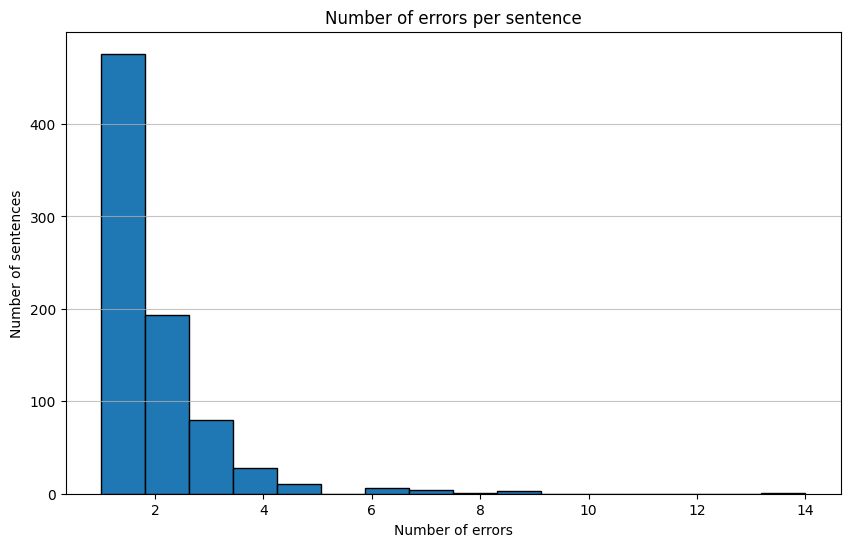

In [50]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [51]:
# Show prediction errors for sentences with more than 5 errors.
for s in hard_sentences:
    if s[1] > 5:
        print(" ".join(untag(s[0])))
        print('Number of errors:', s[1])
        for i in range(len(s[0])):
            if s[0][i][1] != s[2][i]:
                print(f'{s[0][i][0]:<20}  C: {s[0][i][1]:<12}  P: {s[2][i]:<12} **** Error')
            else:
                print(f'{s[0][i][0]:<23}  {s[0][i][1]:<12}')
        print(40*'=')


Stay with me now : John Paul STEVENS delivered the opinion of the Court with respect to Parts I through IV , VI through VI - D - iii , VI - D - v , and VII , in which KENNEDY , SOUTER , GINSBURG , and BREYER joined , and an opinion with respect to Parts V and VI - D - iv , in which SOUTER , GINSBURG , and BREYER joined .
Number of errors: 8
Stay                     VERB        
with                     ADP         
me                       PRON        
now                      ADV         
:                        PUNCT       
John                     PROPN       
Paul                     PROPN       
STEVENS               C: PROPN         P: NOUN         **** Error
delivered                VERB        
the                      DET         
opinion                  NOUN        
of                       ADP         
the                      DET         
Court                    NOUN        
with                     ADP         
respect                  NOUN        
to                   

## Error Analysis

1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).
2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.
3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.


## 1.2.3

In [52]:
tokens = collections.defaultdict(list)
sen_ids = [] 
for i, s in enumerate(hard_sentences):
    words = [word for word, _ in hard_sentences[i][0]]
    full_s = ' '.join(words)
    sen_ids.append(full_s)
    for j in range(len(s[0])):
        if s[0][j][1] != s[2][j]:
            tokens[s[0][j][0]].append(i)

sentences = set()
print("Tokens with more than 10 errors:")
for token, lst in tokens.items():
    if len(lst) > 10:
        print(token)
        for index in lst:
            sentences.add(sen_ids[index])

print("Total amount of sentences:", len(sentences))

print("Sentences where the errors are predicted:\n")
for s in sentences:
    print(s)

Tokens with more than 10 errors:
out
on
as
to
/
that
for
up
like
in
01-Feb-02
Total amount of sentences: 179
Sentences where the errors are predicted:

I 'm looking for a camera that has really good zoom during a video and pictures ; and good quality pictures / videos
My pharmacy order is always correct and promptly delivered but the pharmacy staff are always very short with me and do n't seem to like answering questions .
Thank you for your help in tracking these invoices .
Feels like you are in Brooklyn , but people watching is entertaining .
Would love for you to join us .
Clean store , friendly check - out staff up front .
I could go on and on !
EY4106.7 PERFORMANCE 01-Feb-02 P 1,993,045 - $ 43,548
It looks as if NASA is transitioning away from the shuttle model , as in the past they have proven to be quite dangerous as Columbia has recently proved .
Perhaps , we should start with just a 1 or 2 day contract where I give some thoughts to the kind of issues that we discussed and come

## 1.2.4

These errors are most likely made by the tagger due to their high likeliness of morphological amiguity and the high frequencies that they appear.
The words that appear in this list have multiple possible pos tags / gramatical functions.

For example:

that: Can be a demonstrative determiner (DET), a pronoun (PRON), or a subordinating conjunction (SCONJ)

as: Switches between subordinating conjunction (SCONJ), adposition (ADP), and adverb (ADV)

to: Often confused between particle (PART) and adposition (ADP)

like: Has many possible tags (SCONJ, ADP, VERB, ADJ)
etc.

"01-Feb-02" is probably OOV and our model does not handle these cases well due to not using a subword tokenizer and its limited context window.

The logistic regression model lacks the ability to capture long-range dependencies and hierarchical sentence structure needed to consistently disambiguate these challenging cases.


## 1.2.5



i. "That book that I read stated that that theory was flawed."

Method: Using "that" in multiple roles (DET, PRON, SCONJ, DET) in a single sentence to confuse the tagger.


ii. "As I waited for the train, I stood as still as a statue for what felt like hours."

Method: Using "as" and "for" in different syntactic roles that require broader context to disambiguate correctly.


iii. "The stock went up as prices went down, but investors need to figure out how to build up reserves."

Method: Including directional words ("up", "down", "out", "up") in different contexts (ADV, PART, ADP) to exploit the tagger's confusion with these terms.


iv. "I'd like a jacket like that one, since companies like Nike make products with a sport-like appearance."

Method: Using "like" in three different roles (VERB, ADP, ADJ) to challenge the tagger's ability to distinguish these uses.

v. "We went skiing on 17-Jan-23 in Salt Lake City."

Method: Using "17-Jan-23" which is most likely oov in our dataset.



## 2.1


In [53]:
import os
from openai import OpenAI
from pydantic import BaseModel, Field
from enum import Enum
from typing import List, Optional
import json  


model = 'grok-3-mini'

In [54]:
# --- Define the Universal Dependencies POS Tagset (17 core tags) as an enum ---
class UDPosTag(str, Enum):
    ADJ = "ADJ"     # adjective
    ADP = "ADP"     # adposition
    ADV = "ADV"     # adverb
    AUX = "AUX"     # auxiliary verb
    CCONJ = "CCONJ" # coordinating conjunction
    DET = "DET"     # determiner
    INTJ = "INTJ"   # interjection
    NOUN = "NOUN"   # noun
    NUM = "NUM"     # numeral
    PART = "PART"   # particle
    PRON = "PRON"   # pronoun
    PROPN = "PROPN" # proper noun
    PUNCT = "PUNCT" # punctuation
    SCONJ = "SCONJ" # subordinating conjunction
    SYM = "SYM"     # symbol
    VERB = "VERB"   # verb
    X = "X"         # other / unknown


In [56]:
# Define Pydantic models for structured output
class TokenPOS(BaseModel):
    text: str = Field(description="The token text")
    pos_tag: UDPosTag = Field(description="The Universal Dependencies POS tag")

class SentencePOS(BaseModel):
    tokens: List[TokenPOS] = Field(description="List of tokens with their POS tags")

class TaggedSentences(BaseModel):
    """Represents a list of sentences with their tagged tokens."""
    sentences: List[SentencePOS] = Field(description="A list of sentences, each containing tagged tokens.")

# --- Configure the Grok API ---

try:
    # Attempt to get API key from environment variable
    def load_env_from_ini(filename):
        with open(filename) as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                key, value = line.split('=', 1)
                os.environ[key.strip()] = value.strip()

    # Load the API key
    load_env_from_ini("grok_key.ini")
    api_key = os.environ.get("GROK_API_KEY")
    if not api_key:
        # Fallback or specific instruction for local setup
        api_key = "YOUR_API_KEY"
        if api_key == "YOUR_API_KEY":
           print("⚠️ Warning: API key not found in environment variables. Using placeholder.")
           print("   Please set the GROK_API_KEY environment variable or replace 'YOUR_API_KEY' in the code.")

    client = OpenAI(
        api_key=api_key,
        base_url="https://api.x.ai/v1",
    )

except Exception as e:
    print(f"Error configuring API: {e}")
    print("Please ensure you have a valid API key set.")



In our first attempt to prompt the model, we sent the list of sentences that we would like to tag in a JSON list format. ie - [sent1, sent2, ...]

We noticed that the sentences were not being segmented the same way as the lr tagger was recieving the sentences to tag, so we decided to send the model already tokenized sentences. We sent a nested JSON list of tokeized sentences. ie - [[tok1, tok2, ...], [tok1, tok2, ...], ...] - that is the second attempt.

### First Attempt

In [65]:
def tag_sentences_ud(sentences_json: str) -> Optional[TaggedSentences]:
    """
    Performs POS tagging on the input list of sentences using the Grok API and
    returns the result structured according to the TaggedSentences Pydantic model.
    
    Args:
        sentences_json: JSON string containing one or more sentences to tag
        
    Returns:
        A TaggedSentences object containing the tagged tokens, or None if an error occurs.
    """
    # Construct the prompt with JSON input format
    prompt = f"""You are a specialized POS tagger following Universal Dependencies (UD_English-EWT) conventions that outputs precise structured JSON.
    
    I will provide you with a JSON array of sentences to tag. Process each sentence separately.
    
    Tag each token with Universal Dependencies (UD) POS tags:
    ADJ=adjective, ADP=adposition, ADV=adverb, AUX=auxiliary, CCONJ=coordinating conjunction, DET=determiner, 
    INTJ=interjection, NOUN=noun, NUM=numeral, PART=particle, PRON=pronoun, PROPN=proper noun, 
    PUNCT=punctuation, SCONJ=subordinating conjunction, SYM=symbol, VERB=verb, X=other
    
    Rules:
    - Split on whitespace and punctuation (except in URLs, numbers, abbreviations)
    - Split contractions: "don't" → ["Do", "n't"], "it's" → ["It", "'s"]
    - Separate possessives: "Elena's" → ["Elena", "'s"]
    - Split hyphenated compounds: "search-engine" → ["search", "-", "engine"]
    - Keep punctuation as separate tokens
    - Preserve numbers with internal periods/commas (e.g., 3.14, 1,000)
    - Do not merge words except for contractions/clitics
    - if there is a sentence equal to "..." tag it as "PUNCT", don't ignore it.
    - make sure you don't skip any tokens or strings. tag all tokens.
    
    Input JSON array of sentences:
    {sentences_json}
    """

    completion = client.beta.chat.completions.parse(
        model="grok-3",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_format=TaggedSentences,
    )
    
    res = completion.choices[0].message.parsed
    return res



In [66]:
import concurrent
from ratelimit import limits, sleep_and_retry


@sleep_and_retry
@limits(calls=5, period=1)  # 5 calls per second
def rate_limited_tag(sentences_json: str) -> Optional[TaggedSentences]:
    return tag_sentences_ud(sentences_json)

def batch_tag_sentences_ud(sentences: List[str], batch_size: int = 15) -> List[TaggedSentences]:
    """Process sentences in parallel with rate limiting using JSON formatting"""
    batches = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        # Convert batch to JSON string 
        batch_json = json.dumps(batch)
        batches.append(batch_json)
    
    print(f"Processing {len(batches)} batches with parallel workers...")
    results = [None] * len(batches)
    
    # Use ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Submit all tasks to the executor
        future_to_batch = {executor.submit(rate_limited_tag, batch_json): i 
                          for i, batch_json in enumerate(batches)}
        
        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_batch):
            batch_idx = future_to_batch[future]
            try:
                result = future.result()
                if result:
                    results[batch_idx] = result
                    print(f"Completed batch {batch_idx+1}/{len(batches)}")
                else:
                    print(f"Failed batch {batch_idx+1}/{len(batches)}")
            except Exception as e:
                print(f"Error processing batch {batch_idx+1}: {e}")
    
    return results


In [67]:
import collections
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
    
llm_hard_sentences = []
llm_error_data = []

def evaluate_llm_tagger(results_llm, lr_hard_sentences, batch_size=5):
    """
    Evaluates the LLM tagger results against ground truth, handling potential misalignments.
    
    Args:
        results_llm: List of TaggedSentences results from the LLM
        lr_hard_sentences: List of (sentence, errors, lr_tags, idx) tuples with ground truth
        batch_size: The batch size used when processing sentences
    
    Returns:
        Metrics for the LLM tagger performance
    """
    
    # Filter out None results
    results_llm = [r for r in results_llm if r is not None]
    
    # Create batch-aware mapping of results
    batched_sentences = [lr_hard_sentences[i:i+batch_size] for i in range(0, len(lr_hard_sentences), batch_size)]
    
    llm_pred = []
    llm_words = []
    sentence_mapping = {}  # Maps original index to result index
    
    print(f"Type of results_llm[0]: {type(results_llm[0]) if results_llm else 'No results'}")
    
    # Process each batch separately
    for batch_idx, batch in enumerate(batched_sentences):
        if batch_idx >= len(results_llm):
            print(f"Missing results for batch {batch_idx}")
            continue
            
        batch_result = results_llm[batch_idx]
        
        # Check if it has sentences attribute
        if hasattr(batch_result, 'sentences'):
            result_sentences = batch_result.sentences
        elif hasattr(batch_result, 'tokens'):
            # Handle single-sentence result case
            result_sentences = [batch_result]
        else:
            print(f"Unknown structure for batch {batch_idx}: {dir(batch_result)}")
            continue
        
        # Check if we got the expected number of sentences
        if len(result_sentences) != len(batch):
            print(f"Warning: Batch {batch_idx} returned {len(result_sentences)} sentences, expected {len(batch)}")
        
        # Map each input sentence to its result (or None if missing)
        for i, (s, errors, lr_tags, idx) in enumerate(batch):
            orig_idx = batch_idx * batch_size + i  # Original index in lr_hard_sentences
            
            if i < len(result_sentences):
                # We have a result for this sentence
                pred = [token.pos_tag for token in result_sentences[i].tokens]
                words = [token.text for token in result_sentences[i].tokens]
                llm_pred.append(pred)
                llm_words.append(words)
                sentence_mapping[orig_idx] = len(llm_pred) - 1
            else:
                # No result for this sentence - don't add to llm_pred/llm_words, but record this in mapping
                print(f"No prediction available for sentence {orig_idx}")
                sentence_mapping[orig_idx] = None
    
    # Only proceed with metrics if we have predictions
    if len(llm_pred) > 0:
        global llm_hard_sentences
        global llm_error_data
        llm_hard_sentences = []
        fixed_by_llm = 0
        new_errors_by_llm = 0
        llm_error_data = []
        mismatches = 0
        
        all_true_tags = []
        all_pred_tags = []
        all_words = []
        
        for i, (s, errors, lr_tags, idx) in enumerate(lr_hard_sentences):
            # Use the mapping to get the correct prediction index
            if i not in sentence_mapping or sentence_mapping[i] is None:
                print(f"Skipping sentence {i} - no prediction available")
                continue
                
            pred_idx = sentence_mapping[i]
            words = [word for word, _ in s]
            true_tags = [true_tag for _, true_tag in s]
            pred_tags = llm_pred[pred_idx]
            
            # Checks length of tokens should match
            if len(true_tags) != len(pred_tags) or len(pred_tags) != len(words):
                print(f"Length mismatch in sentence {i}: true={len(true_tags)}, pred={len(pred_tags)}")
                mismatches += 1
                continue
            
            all_true_tags.extend([tag.value if hasattr(tag, 'value') else str(tag) for tag in true_tags])
            all_pred_tags.extend([tag.value if hasattr(tag, 'value') else str(tag) for tag in pred_tags])
            all_words.extend(words)


            llm_errors = 0
            for j in range(len(words)):
                if true_tags[j] != pred_tags[j]:
                    llm_errors += 1
                    llm_error_data.append((words[j], true_tags[j], pred_tags[j]))
                    
                lr_wrong = lr_tags[j] != true_tags[j]
                llm_wrong = pred_tags[j] != true_tags[j]
                
                if lr_wrong and not llm_wrong:
                    fixed_by_llm += 1
                if not lr_wrong and llm_wrong:
                    new_errors_by_llm += 1
                    
            if llm_errors > 0:
                llm_hard_sentences.append((s, llm_errors))
        
        print(f'Number of sentences with errors (llm): {len(llm_hard_sentences)} out of {len(lr_hard_sentences)} (lr)')
        print(f"Errors fixed by LLM: {fixed_by_llm}")
        print(f"New errors made by LLM: {new_errors_by_llm}")
        print(f"Mismatches in sentence length: {mismatches}")
        
        if len(all_true_tags) > 0:
            print("\n--- LLM Tagger Token-Level Metrics ---")
            llm_accuracy = accuracy_score(all_true_tags, all_pred_tags)
            llm_f1_macro = f1_score(all_true_tags, all_pred_tags, average='macro')
            print(f"Accuracy: {llm_accuracy:.4f}")
            print(f"F1-macro score: {llm_f1_macro:.4f}")
            
            print("\nClassification Report for LLM Tagger:")
            print(classification_report(all_true_tags, all_pred_tags, digits=4))
            
            classes = sorted(list(set(all_true_tags)))
            cnf_matrix = confusion_matrix(all_true_tags, all_pred_tags)
            f1 = f1_score(all_true_tags, all_pred_tags, average='macro')
            plot_confusion_matrix(f1, cnf_matrix, target_names=classes, 
                                title='Confusion matrix for LLM Tagger', normalize=False)
            
            error_counter = collections.Counter()
            total_errors = 0
            for i in range(len(all_true_tags)):
                if all_true_tags[i] != all_pred_tags[i]:
                    total_errors += 1
                    word = all_words[i]
                    error_counter[word] += 1
            
            print("\nFrequent Types of Mistakes:")
            print(f'Accuracy: {(len(all_true_tags)-total_errors)/len(all_true_tags):.4f}')
            print(f'Total errors/Total words: {total_errors}/{len(all_true_tags)}\n')
            print('Most common errors:', error_counter.most_common(20))
            
            return {
                'accuracy': llm_accuracy,
                'f1_macro': llm_f1_macro,
                'fixed_by_llm': fixed_by_llm,
                'new_errors_by_llm': new_errors_by_llm,
                'mismatches': mismatches,
                'error_data': llm_error_data,
                'hard_sentences': llm_hard_sentences
            }
        else:
            print("No data available to calculate metrics")
            return None
    else:
        print("No LLM predictions available to calculate metrics")
        return None


Processing 150 batches with parallel workers...
Completed batch 1/150
Completed batch 2/150
Completed batch 10/150
Completed batch 5/150
Completed batch 3/150
Completed batch 7/150
Completed batch 9/150
Completed batch 4/150
Completed batch 8/150
Completed batch 6/150
Completed batch 13/150
Completed batch 16/150
Completed batch 11/150
Completed batch 12/150
Completed batch 20/150
Completed batch 21/150
Completed batch 22/150
Completed batch 19/150
Completed batch 15/150
Completed batch 14/150
Completed batch 17/150
Completed batch 18/150
Completed batch 25/150
Completed batch 28/150
Completed batch 30/150
Completed batch 23/150
Completed batch 24/150
Completed batch 33/150
Completed batch 26/150
Completed batch 29/150
Completed batch 27/150
Completed batch 35/150
Completed batch 32/150
Completed batch 36/150
Completed batch 31/150
Completed batch 39/150
Completed batch 34/150
Completed batch 38/150
Completed batch 37/150
Completed batch 40/150
Completed batch 43/150
Completed batch 41

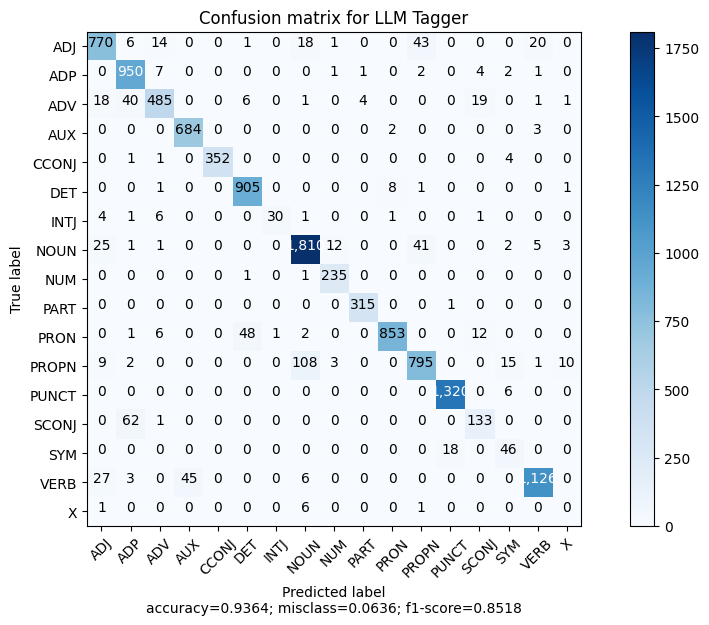

In [70]:
lr_hard_sentences = [s for s in hard_sentences if 1 <= s[1] <= 3]
sentences = [" ".join(untag(pairs)) for pairs, _, _ , _ in lr_hard_sentences]
results_llm = batch_tag_sentences_ud(sentences, batch_size=5)
metric = evaluate_llm_tagger(results_llm, lr_hard_sentences, batch_size=5)

### Second Attempt

In [71]:
import collections
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
    
def evaluate_llm_tagger(results_llm, lr_hard_sentences, batch_size=5, collect_error_context=True):
    """
    Evaluates the LLM tagger results against ground truth, and collects comprehensive error data for analysis.
    
    Args:
        results_llm: List of TaggedSentences results from the LLM
        lr_hard_sentences: List of (sentence, errors, lr_tags, idx) tuples with ground truth
        batch_size: The batch size used when processing sentences
        collect_error_context: Whether to collect detailed context for error analysis
    
    Returns:
        Dictionary with metrics and error analysis data
    """
    
    # Filter out None results
    results_llm = [r for r in results_llm if r is not None]
    
    # Create batch-aware mapping of results
    batched_sentences = [lr_hard_sentences[i:i+batch_size] for i in range(0, len(lr_hard_sentences), batch_size)]
    
    llm_pred = []
    llm_words = []
    sentence_mapping = {}  # Maps original index to result index
    
    # Process all batches
    for batch_idx, batch in enumerate(batched_sentences):
        if batch_idx >= len(results_llm):
            print(f"Missing results for batch {batch_idx}")
            continue
            
        batch_result = results_llm[batch_idx]
        
        # Check if it has sentences attribute
        if hasattr(batch_result, 'sentences'):
            result_sentences = batch_result.sentences
        elif hasattr(batch_result, 'tokens'):
            # Handle single-sentence result case
            result_sentences = [batch_result]
        else:
            print(f"Unknown structure for batch {batch_idx}: {dir(batch_result)}")
            continue
        
        # Check if we got the expected number of sentences
        if len(result_sentences) != len(batch):
            print(f"Warning: Batch {batch_idx} returned {len(result_sentences)} sentences, expected {len(batch)}")
        
        # Map each input sentence to its result (or None if missing)
        for i, (s, errors, lr_tags, idx) in enumerate(batch):
            orig_idx = batch_idx * batch_size + i  # Original index in lr_hard_sentences
            
            if i < len(result_sentences):
                # We have a result for this sentence
                pred = [token.pos_tag for token in result_sentences[i].tokens]
                words = [token.text for token in result_sentences[i].tokens]
                llm_pred.append(pred)
                llm_words.append(words)
                sentence_mapping[orig_idx] = len(llm_pred) - 1
            else:
                # No result for this sentence
                print(f"No prediction available for sentence {orig_idx}")
                # Don't add to llm_pred/llm_words, but record this in mapping
                sentence_mapping[orig_idx] = None
    
    # Only create metrics if we have predictions
    if len(llm_pred) > 0:
        global llm_hard_sentences
        global llm_error_data
        llm_hard_sentences = []
        fixed_by_llm = 0
        new_errors_by_llm = 0
        llm_error_data = []
        detailed_error_data = []  # For error analysis with context
        mismatches = 0
        
        all_true_tags = []
        all_pred_tags = []
        all_words = []
        
        for i, (s, errors, lr_tags, idx) in enumerate(lr_hard_sentences):
            # Use the mapping to get the correct prediction index
            if i not in sentence_mapping or sentence_mapping[i] is None:
                print(f"Skipping sentence {i} - no prediction available")
                continue
                
            pred_idx = sentence_mapping[i]
            words = [word for word, _ in s]
            true_tags = [true_tag for _, true_tag in s]
            pred_tags = llm_pred[pred_idx]
            
            # Sanity check- length of tokens should match
            if len(true_tags) != len(pred_tags) or len(pred_tags) != len(words):
                print(f"Length mismatch in sentence {i}: true={len(true_tags)}, pred={len(pred_tags)}")
                mismatches += 1
                continue
            
            all_true_tags.extend([tag.value if hasattr(tag, 'value') else str(tag) for tag in true_tags])
            all_pred_tags.extend([tag.value if hasattr(tag, 'value') else str(tag) for tag in pred_tags])
            all_words.extend(words)

            llm_errors = 0
            sentence_text = " ".join(words)
            
            for j in range(len(words)):
                true_tag = true_tags[j]
                pred_tag = pred_tags[j]
                word = words[j]
                
                if true_tag != pred_tag:
                    llm_errors += 1
                    llm_error_data.append((word, true_tag, pred_tag))
                    
                    # Enhanced error data with context for error analysis
                    if collect_error_context:
                        detailed_error_data.append({
                            "word": word,
                            "correct_tag": true_tag.value if hasattr(true_tag, 'value') else str(true_tag),
                            "predicted_tag": pred_tag.value if hasattr(pred_tag, 'value') else str(pred_tag),
                            "sentence_context": sentence_text,
                            "word_index": j,
                            # Store surrounding words for context window
                            "context_window": words[max(0, j-3):min(len(words), j+4)],
                            # Mark if this was also wrong in LR model
                            "also_wrong_in_lr": lr_tags[j] != true_tag
                        })
                
                lr_wrong = lr_tags[j] != true_tag
                llm_wrong = pred_tag != true_tag
                
                if lr_wrong and not llm_wrong:
                    fixed_by_llm += 1
                if not lr_wrong and llm_wrong:
                    new_errors_by_llm += 1
                    
            if llm_errors > 0:
                llm_hard_sentences.append((s, llm_errors))
        
        print(f'Number of sentences with errors (llm): {len(llm_hard_sentences)} out of {len(lr_hard_sentences)} (lr)')
        print(f"Errors fixed by LLM: {fixed_by_llm}")
        print(f"New errors made by LLM: {new_errors_by_llm}")
        print(f"Mismatches in sentence length: {mismatches}")
        
        if len(all_true_tags) > 0:
            print("\n--- LLM Tagger Token-Level Metrics ---")
            llm_accuracy = accuracy_score(all_true_tags, all_pred_tags)
            llm_f1_macro = f1_score(all_true_tags, all_pred_tags, average='macro')
            print(f"Accuracy: {llm_accuracy:.4f}")
            print(f"F1-macro score: {llm_f1_macro:.4f}")
            
            print("\nClassification Report for LLM Tagger:")
            print(classification_report(all_true_tags, all_pred_tags, digits=4))
            
            classes = sorted(list(set(all_true_tags)))
            cnf_matrix = confusion_matrix(all_true_tags, all_pred_tags)
            f1 = f1_score(all_true_tags, all_pred_tags, average='macro')
            plot_confusion_matrix(f1, cnf_matrix, target_names=classes,
                                title='Confusion matrix for LLM Tagger', normalize=False)
            
            # most common errors
            error_counter = collections.Counter()
            total_errors = 0
            for i in range(len(all_true_tags)):
                if all_true_tags[i] != all_pred_tags[i]:
                    total_errors += 1
                    word = all_words[i]
                    error_counter[word] += 1
            
            print("\nFrequent Types of Mistakes:")
            print(f'Accuracy: {(len(all_true_tags)-total_errors)/len(all_true_tags):.4f}')
            print(f'Total errors/Total words: {total_errors}/{len(all_true_tags)}\n')
            print('Most common errors:', error_counter.most_common(20))
            
            return {
                'accuracy': llm_accuracy,
                'f1_macro': llm_f1_macro,
                'fixed_by_llm': fixed_by_llm,
                'new_errors_by_llm': new_errors_by_llm,
                'mismatches': mismatches,
                'error_data': llm_error_data,
                'detailed_error_data': detailed_error_data, 
                'hard_sentences': llm_hard_sentences,
                'error_counts': error_counter
            }
        else:
            print("No data available to calculate metrics")
            return None
    else:
        print("No LLM predictions available to calculate metrics")
        return None


## 2.2.1 - 2.2.3

Processing 150 batches of pre-tokenized sentences
Completed batch 1/150
Completed batch 2/150
Completed batch 3/150
Completed batch 5/150
Completed batch 7/150
Completed batch 9/150
Completed batch 10/150
Completed batch 4/150
Completed batch 6/150
Completed batch 8/150
Completed batch 13/150
Completed batch 16/150
Completed batch 11/150
Completed batch 20/150
Completed batch 12/150
Completed batch 19/150
Completed batch 21/150
Completed batch 15/150
Completed batch 14/150
Completed batch 22/150
Completed batch 18/150
Completed batch 25/150
Completed batch 23/150
Completed batch 30/150
Completed batch 32/150
Completed batch 24/150
Completed batch 29/150
Completed batch 26/150
Completed batch 27/150
Completed batch 33/150
Completed batch 35/150
Completed batch 36/150
Completed batch 39/150
Completed batch 34/150
Completed batch 38/150
Completed batch 28/150
Completed batch 37/150
Completed batch 31/150
Completed batch 40/150
Completed batch 17/150
Completed batch 48/150
Completed batch 

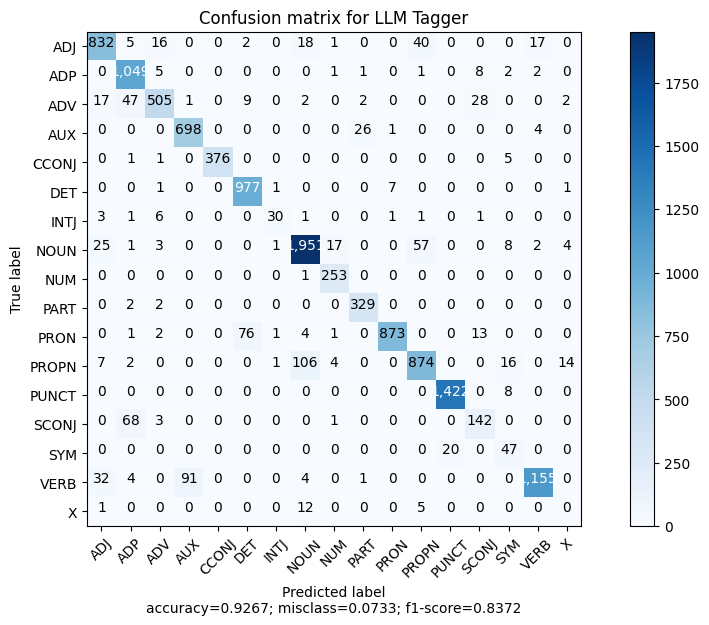

In [72]:
import concurrent
from ratelimit import limits, sleep_and_retry 

def tag_pretokenized_sentences(tokenized_sentences_json: str) -> Optional[TaggedSentences]:
    """
    Performs POS tagging on pre-tokenized sentences using the Grok API.
    
    Args:
        tokenized_sentences_json: JSON string containing a list of tokenized sentences, 
                                  where each sentence is a list of tokens
        
    Returns:
        A TaggedSentences object containing the tagged tokens, or None if an error occurs.
    """
    # Construct the prompt with pre-tokenized input format
    prompt = f"""You are a specialized POS tagger following Universal Dependencies (UD_English-EWT) conventions.
    
    I will provide you with a JSON array where each element is a pre-tokenized sentence (a list of tokens).
    Your task is ONLY to assign the correct Universal Dependencies POS tag to each token.
    DO NOT modify the tokenization in any way - use exactly the tokens provided.
    
    Tag each token with one of these Universal Dependencies POS tags:
    ADJ=adjective, ADP=adposition, ADV=adverb, AUX=auxiliary, CCONJ=coordinating conjunction, DET=determiner,
    INTJ=interjection, NOUN=noun, NUM=numeral, PART=particle, PRON=pronoun, PROPN=proper noun,
    PUNCT=punctuation, SCONJ=subordinating conjunction, SYM=symbol, VERB=verb, X=other
    
    Important guidelines:
    - DO NOT change, merge, or split any tokens - use exactly the tokens provided
    - If a token is "..." tag it as PUNCT
    - Tag all tokens - do not skip any
    - Contractions like "n't" should be tagged as PART
    - Possessive markers like "'s" should be tagged as PART
    - Proper nouns (names of specific entities) should be tagged as PROPN
    - Auxiliary verbs (be, have, do, will, etc.) should be tagged as AUX
    
    Input JSON array of pre-tokenized sentences:
    {tokenized_sentences_json}
    """

    completion = client.beta.chat.completions.parse(
        model="grok-3",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_format=TaggedSentences,
    )
    
    res = completion.choices[0].message.parsed
    return res

@sleep_and_retry
@limits(calls=5, period=1)  # 5 calls per second
def rate_limited_tag_pretokenized(tokenized_sentences_json: str) -> Optional[TaggedSentences]:
    return tag_pretokenized_sentences(tokenized_sentences_json)

def batch_tag_pretokenized_sentences(tokenized_sentences: List[List[str]], batch_size: int = 15) -> List[TaggedSentences]:
    """
    Process pre-tokenized sentences in batches using JSON formatting
    
    Args:
        tokenized_sentences: List of tokenized sentences, where each sentence is a list of tokens
        batch_size: Number of sentences to process in each batch
        
    Returns:
        List of TaggedSentences results
    """
    batches = []
    for i in range(0, len(tokenized_sentences), batch_size):
        batch = tokenized_sentences[i:i+batch_size]
        # Convert batch to JSON string
        batch_json = json.dumps(batch)
        batches.append(batch_json)
    
    print(f"Processing {len(batches)} batches of pre-tokenized sentences")
    results = [None] * len(batches)
    
    # Use ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Submit all tasks to the executor
        future_to_batch = {executor.submit(rate_limited_tag_pretokenized, batch_json): i 
                          for i, batch_json in enumerate(batches)}
        
        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_batch):
            batch_idx = future_to_batch[future]
            try:
                result = future.result()
                if result:
                    results[batch_idx] = result
                    print(f"Completed batch {batch_idx+1}/{len(batches)}")
                else:
                    print(f"Failed batch {batch_idx+1}/{len(batches)}")
            except Exception as e:
                print(f"Error processing batch {batch_idx+1}: {e}")
    
    return results

lr_hard_sentences = [s for s in hard_sentences if 1 <= s[1] <= 3]
tokenized_sentences = [untag(pairs) for pairs, _, _, _ in lr_hard_sentences]
results_llm = batch_tag_pretokenized_sentences(tokenized_sentences, batch_size=5)

metrics = evaluate_llm_tagger(results_llm, lr_hard_sentences, batch_size=5)

## 2.2.4

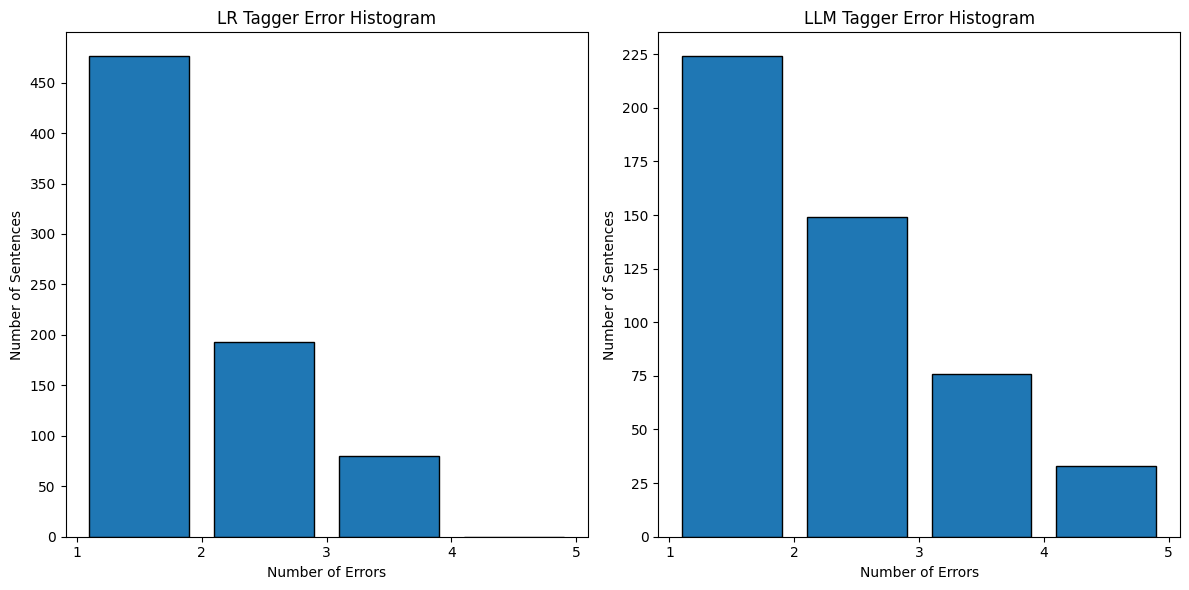

In [73]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  

# Plot the histogram for LR
ax[0].hist([x[1] for x in lr_hard_sentences], bins=range(1, 6), edgecolor='black', rwidth=0.8)
ax[0].set_title("LR Tagger Error Histogram")
ax[0].set_xlabel("Number of Errors")
ax[0].set_ylabel("Number of Sentences")
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))

# Plot the histogram for LLM
ax[1].hist([errors for s, errors in llm_hard_sentences], bins=range(1, 6), edgecolor='black', rwidth=0.8)
ax[1].set_title("LLM Tagger Error Histogram")
ax[1].set_xlabel("Number of Errors")
ax[1].set_ylabel("Number of Sentences")
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


## 2.2.5
### Our hypotheses about the difficult cases for the LLM tagger:
#### 1. Function Word Ambiguity
The most common errors involve function words that can serve multiple grammatical roles ('have', 'that', 'for', 'to'). The LLM seems to struggle with contextual disambiguation of these highly frequent words.

For example:

"That that I saw yesterday wasn't that interesting, but that that you mentioned seems fascinating."

"For him to succeed, he studied for hours, for the exam was difficult for anyone without preparation."

#### 2. Auxiliary vs. Main Verb Distinction
Words like 'have', 'had', and 'has' appear frequently in the error list. The confusion matrix shows 90 cases where VERB was incorrectly tagged as AUX, suggesting difficulty in distinguishing when these verbs function as auxiliaries versus main verbs.

For example:

"I have three cars but have never had to have them repaired since I have maintained them well."

"She has a dog that has been trained by someone who has expertise in animal behavior."

#### 3. Possessive Constructions
Possessives like "'s", "my", "your", and "our" are common error points, suggesting the LLM struggles with possessive constructions and their correct classification as PART vs. other categories.

For example:

"My sister's friend's car's engine is making that noise that's concerning everyone."

"Your book's cover is torn, but your dedication to your studies is admirable."

#### 4. Preposition vs. Conjunction Ambiguity
The confusion matrix reveals significant confusion between SCONJ and ADP (71 cases), indicating the model struggles with words that can function as either prepositions or subordinating conjunctions.

For example:

"After dinner, we'll discuss what happened after you left."

"Since morning I've been working, since I need to finish this project today."

#### 5. Proper Noun Recognition
There's substantial bidirectional confusion between NOUN and PROPN categories (99 NOUN→PROPN errors, 54 PROPN→NOUN errors), indicating challenges with proper noun identification.

For example:

"Apple hired a new employee to polish Polish furniture made by French workers in the french quarter."

"May I ask if you're available in May to visit Little Rock with little enthusiasm?"

#### 6. Special Characters and Symbols
The tagger has a low F1-score for SYM (0.6144), with 20 cases of SYM being misclassified as PUNCT, suggesting difficulty with non-alphanumeric characters.

For example:

"The equation x^2 + y^2 = z^2 requires careful analysis at a cost of $50 per hour."

"We saw a 25% increase in Q1, followed by a -10% decline, maintaining a 3:1 ratio overall."


## 2.3.1 - 2.3.2

In [74]:
from typing import List, Dict
import time
import random
from collections import Counter
# --- Define the Pydantic model for structured output ---
class ErrorExplanation(BaseModel):
    word: str = Field(description="The word that was incorrectly tagged")
    correct_tag: str = Field(description="The correct UD POS tag")
    predicted_tag: str = Field(description="The incorrectly predicted tag")
    explanation: str = Field(description="Explanation of why the error likely occurred")
    category: str = Field(description="Category of error (e.g., 'Ambiguity', 'Capitalization', etc.)")

class BatchErrorExplanation(BaseModel):
    explanations: List[ErrorExplanation] = Field(description="List of error explanations")

def explain_tagging_errors(
    client,
    error_data: List[Dict],
    batch_size: int = 5,
    sample_size: int = 100,
    delay: float = 1.0
) -> List[Dict]:
    """
    Uses LLM to explain POS tagging errors.
    
    Args:
        client: The LLM API client
        error_data: List of detailed error data dictionaries
        batch_size: Number of errors to process in each batch
        sample_size: Maximum number of errors to sample
        delay: Seconds to wait between API calls
        
    Returns:
        List of dictionaries with error explanations
    """
    # Sample errors if there are too many
    if len(error_data) > sample_size:
        sampled_errors = random.sample(error_data, sample_size)
        print(f"Sampled {sample_size} errors from {len(error_data)} total errors")
    else:
        sampled_errors = error_data
        
    all_explanations = []
    
    for i in range(0, len(sampled_errors), batch_size):
        batch = sampled_errors[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(sampled_errors) + batch_size - 1)//batch_size}")
        
        # Construct the prompt for this batch
        prompt = """
        You are a computational linguist specializing in part-of-speech tagging using Universal Dependencies (UD).
        
        I will provide you with words that were incorrectly tagged by a POS tagger. 
        For each error, analyze why the error occurred and assign it to a specific category.
        
        For each error, provide:
        1. A 1-3 sentence explanation of why this specific error likely occurred
        2. A category name that captures the linguistic phenomenon behind the error
        
        Some possible error categories include:
        - Ambiguity (ADJ/NOUN)
        - Proper Noun vs Common Noun
        - Function Word Misclassification
        - Numeral/Ordinal Ambiguity
        - Capitalization Issues
        - Punctuation vs Symbol
        - Auxiliary vs Main Verb Confusion
        - Preposition/Adverb/Particle Ambiguity
        - Contextual Dependency
        
        You may create new category names if needed, but be specific and consistent.
        
        Return your analysis as a structured list of explanations.
        """
        
        # Add errors to the prompt
        for error in batch:
            word = error["word"]
            correct_tag = error["correct_tag"]
            predicted_tag = error["predicted_tag"]
            context = error["sentence_context"]
            
            prompt += f"""

            ERROR:
            Word: {word}
            Correct tag: {correct_tag}
            Predicted tag: {predicted_tag}
            Context: {context}
            """
        
        try:
            completion = client.beta.chat.completions.parse(
                model="grok-3",  
                messages=[{"role": "system", "content": prompt}],
                response_format=BatchErrorExplanation,
            )
            
            batch_explanations = completion.choices[0].message.parsed.explanations
            all_explanations.extend([exp.dict() for exp in batch_explanations])
            
            # Respect API rate limits
            time.sleep(delay)
            
        except Exception as e:
            print(f"Error processing batch: {e}")
            print("Will try again with individual errors")
            
            # Fall back to processing individual errors
            for error in batch:
                individual_prompt = prompt + f"""
                
                ERROR:
                Word: {error["word"]}
                Correct tag: {error["correct_tag"]}
                Predicted tag: {error["predicted_tag"]}
                Context: {error["sentence_context"]}
                """
                
                try:
                    single_completion = client.beta.chat.completions.parse(
                        model="grok-3",
                        messages=[{"role": "system", "content": individual_prompt}],
                        response_format=ErrorExplanation,
                    )
                    
                    explanation = single_completion.choices[0].message.parsed
                    all_explanations.append(explanation.dict())
                    time.sleep(delay)
                except Exception as inner_e:
                    print(f"Error processing individual error: {inner_e}")
    
    return all_explanations

def analyze_error_categories(explanations):
    """Analyze the error explanations and visualize categories."""
    # Extract categories
    categories = [expl["category"] for expl in explanations]
    category_counter = Counter(categories)
    
    print("\nError Categories:")
    for category, count in category_counter.most_common():
        print(f"{category}: {count}")
    
    plt.figure(figsize=(12, 8))
    categories, counts = zip(*category_counter.most_common())
    plt.barh(categories, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Number of Occurrences")
    plt.title("POS Tagging Error Categories")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()  # Most common at the top
    plt.show()
    
    return category_counter

def run_error_analysis(client, evaluation_results):
    """
    Run the complete error analysis process.
    
    Args:
        client: The LLM API client
        evaluation_results: Results from evaluate_llm_tagger function
        
    Returns:
        Error explanations and category analysis
    """
    if not evaluation_results or 'detailed_error_data' not in evaluation_results:
        print("No detailed error data available")
        return None
    
    explanations = explain_tagging_errors(
        client,
        evaluation_results['detailed_error_data'],
        batch_size=5,
        sample_size=50  
    )
    
    category_counts = analyze_error_categories(explanations)
    
    print("\nError Explanations:")
    print(json.dumps(explanations, indent=2))
    
    return {
        'explanations': explanations,
        'category_counts': category_counts
    }

Sampled 50 errors from 910 total errors
Processing batch 1/10


C:\Users\97252\AppData\Local\Temp\ipykernel_29984\3351161152.py:100: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  all_explanations.extend([exp.dict() for exp in batch_explanations])


Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10

Error Categories:
Capitalization Issues: 7
Auxiliary vs Main Verb Confusion: 6
Preposition/Conjunction Ambiguity: 3
Proper Noun vs Common Noun: 3
Possessive Pronoun vs Determiner Ambiguity: 2
Preposition/Adverb/Particle Ambiguity: 2
Verb/Adjective Ambiguity: 2
Preposition/Adverb Ambiguity: 2
Adjective vs Adverb Ambiguity: 2
Pronoun/Interjection Ambiguity: 1
Verb Form vs Adjective Ambiguity: 1
Preposition vs Subordinating Conjunction Ambiguity: 1
Adjective vs Verb Form Ambiguity: 1
Adverb vs Subordinating Conjunction Ambiguity: 1
Determiner/Adverb Ambiguity: 1
Noun/Adjective Ambiguity: 1
Ambiguity (ADV/ADJ): 1
Proper Noun vs Adjective Confusion: 1
Ambiguity (PRON/DET): 1
Preposition/Subordinating Conjunction Ambiguity: 1
Symbol vs Proper Noun Confusion: 1
Possessive Particle vs Auxiliary Am

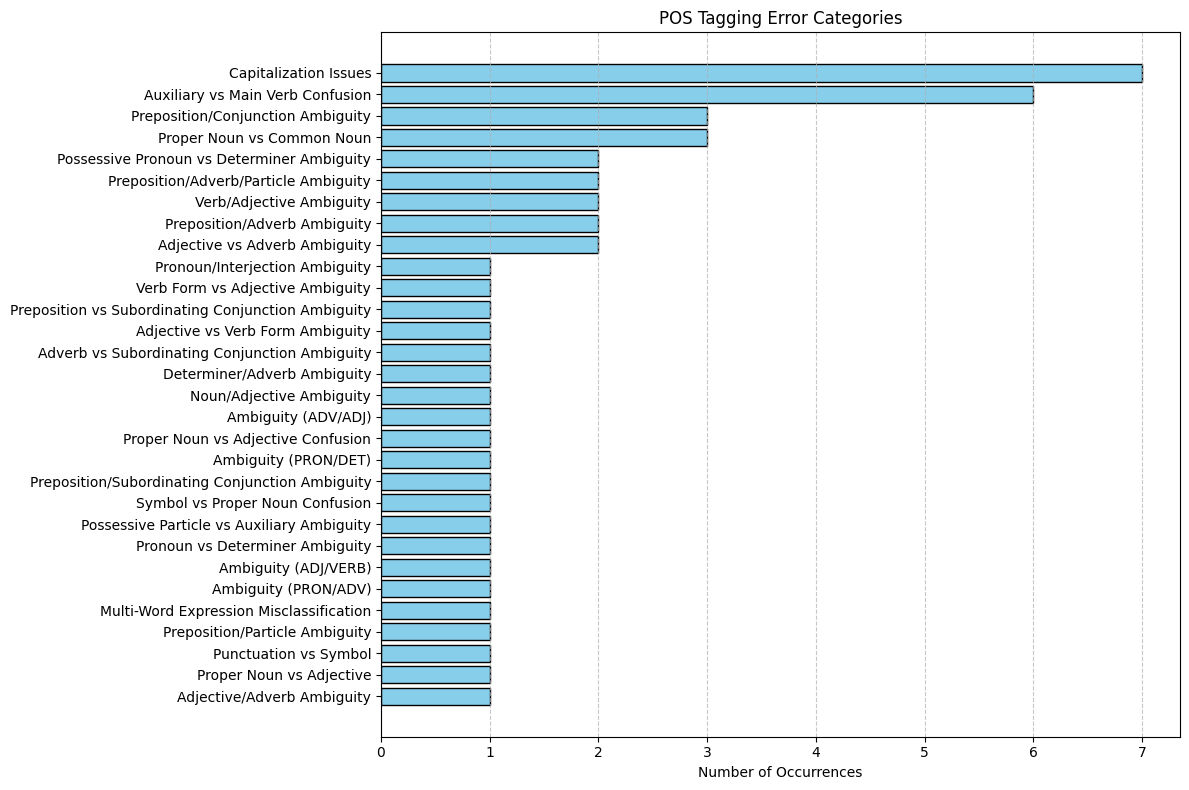


Error Explanations:
[
  {
    "word": "like",
    "correct_tag": "SCONJ",
    "predicted_tag": "ADP",
    "explanation": "The error likely occurred because 'like' can function as both a subordinating conjunction (SCONJ) and a preposition (ADP) depending on the context. In this sentence, 'like' introduces a clause ('The Lunar Transportation Systems, Inc. is visualizing...'), which aligns with its role as a conjunction, but the tagger may have misidentified it as a preposition due to its frequent use in prepositional phrases.",
    "category": "Preposition/Conjunction Ambiguity"
  },
  {
    "word": "Wtf",
    "correct_tag": "PRON",
    "predicted_tag": "INTJ",
    "explanation": "The error likely occurred because 'Wtf' (What the f***), while functioning as a pronoun in this interrogative context ('Wtf is this?'), is often used as an interjection to express surprise or frustration. The tagger may have defaulted to the more common emotional usage as an interjection rather than recognizin

In [75]:
analysis_results = run_error_analysis(client, metrics)

## 2.3.3

In [76]:
from typing import List
from pydantic import BaseModel, RootModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

class SyntheticSentence(BaseModel):
    sentence: List[str]
    tags: List[str]
    categories: List[str] 

class SyntheticBatch(RootModel[List[SyntheticSentence]]):
    pass

# Build prompt dynamically
def build_synthetic_prompt(categories: List[str]) -> str:
    joined = ", ".join(categories)
    return f"""
You are an NLP expert generating training data for a POS tagger.
Generate 2 English sentences that demonstrate POS tagging challenges involving: {joined}.

For each sentence, return:
- A list of tokens
- Their corresponding UD POS tags

Use only the Universal Dependencies POS tagset for tagging (ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X). Each token must receive exactly one tag from this set — no combinations, no ambiguity markers.

Return a valid JSON list like:
[
  {{
    "sentence": [...],
    "tags": [...]
  }},
  ...
]

Only return JSON. Do not explain.
"""

# Generate one batch with retry and category attachment
def generate_batch(categories: List[str], max_retries=3) -> List[SyntheticSentence]:
    prompt = build_synthetic_prompt(categories)

    for attempt in range(max_retries):
        try:
            completion = client.beta.chat.completions.parse(
                model="grok-3",
                messages=[{"role": "system", "content": prompt}],
                response_format=SyntheticBatch,
            )
            results = completion.choices[0].message.parsed.root
            for r in results:
                r.categories = categories
            return [r for r in results if len(r.sentence) == len(r.tags)]
        except Exception as e:
            wait = 2 + random.uniform(0, 2)
            print(f"[Retry {attempt+1}] Error: {e} — waiting {wait:.1f}s")
            time.sleep(wait)

    print(" Failed after retries.")
    return []

# Run multiple batches using weighted sampling from category counts
def run_parallel_generation_from_counter(category_counter, n_batches: int = 200, n_threads: int = 5) -> List[SyntheticSentence]:
    category_pool = list(category_counter.elements()) 
    unique_categories = sorted(set(category_pool))

    all_results = []
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        futures = [
            executor.submit(generate_batch, random.sample(category_pool, k=3))
            for _ in range(n_batches)
        ]
        for future in tqdm(as_completed(futures), total=n_batches):
            batch = future.result()
            all_results.extend(batch)

    return all_results

if __name__ == "__main__":
    category_counter = analysis_results["category_counts"]  

    n_batches = 100   # ≈ 200 sentences
    n_threads = 5

    results = run_parallel_generation_from_counter(category_counter, n_batches=n_batches, n_threads=n_threads)

    print(f"\n Done! Generated {len(results)} synthetic sentences.\n")

    for i, r in enumerate(results[:5]):
        print(f"\n--- Example {i+1} ---")
        print("Sentence:  ", " ".join(r.sentence))
        print("Tags:      ", r.tags)
        print("Categories:", r.categories)


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


 Done! Generated 242 synthetic sentences.


--- Example 1 ---
Sentence:   Spring is beautiful in Paris .
Tags:       ['NOUN', 'AUX', 'ADJ', 'ADP', 'PROPN', 'PUNCT']
Categories: ['Capitalization Issues', 'Possessive Pronoun vs Determiner Ambiguity', 'Proper Noun vs Common Noun']

--- Example 2 ---
Sentence:   Is this Yours or mine ?
Tags:       ['AUX', 'DET', 'PRON', 'CCONJ', 'PRON', 'PUNCT']
Categories: ['Capitalization Issues', 'Possessive Pronoun vs Determiner Ambiguity', 'Proper Noun vs Common Noun']

--- Example 3 ---
Sentence:   She rounded up the team before the game .
Tags:       ['PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT']
Categories: ['Preposition/Conjunction Ambiguity', 'Ambiguity (ADJ/VERB)', 'Possessive Particle vs Auxiliary Ambiguity']

--- Example 4 ---
Sentence:   That 's my book on the shelf .
Tags:       ['DET', 'AUX', 'PRON', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT']
Categories: ['Preposition/Conjunction Ambiguity', 'Ambiguity (ADJ/VERB)', 'Poss

## 2.3.4

In [77]:
def convert_synthetic_to_tagged_sentences(synthetic: List[SyntheticSentence]):
    return [list(zip(s.sentence, s.tags)) for s in synthetic]


if __name__ == "__main__":
    n_batches = 100
    n_threads = 5
    # Convert to training format and combine
    synthetic_tagged = convert_synthetic_to_tagged_sentences(results)
    train_augmented = train_sentences + synthetic_tagged
    random.shuffle(train_augmented)

    print("Vectorizing data...")
    X_train_synth, y_train_synth, X_val_synth, y_val_synth, X_test_synth, y_test_synth, vectorizer_synth = vectorize(train_augmented, val_sentences, test_sentences)

    # Train the LR tagger
    print("Training Logistic Regression...")
    t_ini = datetime.datetime.now()
    clf_synth = LogisticRegression(C=20, solver='liblinear', random_state=13)
    clf_synth.fit(X_train_synth, y_train_synth)
    t_fin = datetime.datetime.now()
    print(f"Training completed in {(t_fin - t_ini).total_seconds():.2f} seconds.")


Vectorizing data...
Feature encoding method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (206598, 98854)
Validation shape: (25151, 98854)
Test shape: (25096, 98854)
Training Logistic Regression...
Training completed in 235.47 seconds.


## 2.3.5

In [78]:
clf.fit(X_train, y_train)
y_pred_orig = clf.predict(X_test)
y_pred_synth = clf_synth.predict(X_test_synth)

# Track positions where the original was wrong but the synthetic fixed it, and vice versa
fixed_by_synth = []
regressed_by_synth = []
unchanged_errors = []

for i, (true, pred_orig, pred_synth) in enumerate(zip(y_test_synth, y_pred_orig, y_pred_synth)):
    if pred_orig != true and pred_synth == true:
        fixed_by_synth.append((i, true, pred_orig, pred_synth))
    elif pred_orig == true and pred_synth != true:
        regressed_by_synth.append((i, true, pred_orig, pred_synth))
    elif pred_orig != true and pred_synth != true:
        unchanged_errors.append((i, true, pred_orig, pred_synth))

print("Contrastive Error Analysis")
print(f"Fixed errors by synthetic model: {len(fixed_by_synth)}")
print(f"New errors introduced by synthetic model: {len(regressed_by_synth)}")
print(f"Unchanged errors (both models wrong): {len(unchanged_errors)}")

print("\n--- Original Model ---")
print(classification_report(y_test_synth, y_pred_orig, digits=3))

print("\n--- Synthetic-Augmented Model ---")
print(classification_report(y_test_synth, y_pred_synth, digits=3))


Contrastive Error Analysis
Fixed errors by synthetic model: 148
New errors introduced by synthetic model: 219
Unchanged errors (both models wrong): 1229

--- Original Model ---
              precision    recall  f1-score   support

         ADJ      0.921     0.901     0.911      1788
         ADP      0.934     0.959     0.946      2029
         ADV      0.923     0.890     0.906      1191
         AUX      0.979     0.983     0.981      1543
       CCONJ      0.995     0.993     0.994       736
         DET      0.992     0.989     0.991      1897
        INTJ      0.962     0.835     0.894       121
        NOUN      0.904     0.920     0.912      4123
         NUM      0.974     0.980     0.977       542
        PART      0.980     0.977     0.978       649
        PRON      0.985     0.988     0.987      2165
       PROPN      0.882     0.862     0.872      2075
       PUNCT      0.992     0.996     0.994      3096
       SCONJ      0.857     0.810     0.833       384
         SYM

## 3.1

In [79]:
def collect_correct_tokenized_indices(lr_hard_sentences, metrics):
    """
    Collects indices of sentences that were correctly tagged by the LLM in tokenized form.
    
    Args:
        lr_hard_sentences: List of (sentence, errors, lr_tags, idx) tuples
        metrics: Dictionary with metrics from evaluate_llm_tagger
        
    Returns:
        List of indices in test_original
    """
    llm_hard_sentences = metrics.get('hard_sentences', [])
    
    # Create a set of sentences with errors in LLM tagger
    llm_error_sentences = {id(sent) for sent, _ in llm_hard_sentences}
    
    # Collect indices of sentences without errors in LLM tagger
    correct_indices = []
    for sent, _, _, idx in lr_hard_sentences:
        if id(sent) not in llm_error_sentences:
            correct_indices.append(idx)
    
    return correct_indices


def collect_failed_sentences(test_sentences, test_original, correct_indices, batch_size=5):
    """
    Tests the LLM tagger on original sentences and collects those that fail.
    """
    original_sentences = [test_original[idx] for idx in correct_indices]
    tokenized_sentences = [test_sentences[idx] for idx in correct_indices]
    
    results_original = batch_tag_sentences_ud(original_sentences, batch_size=batch_size)
    
    total_sentences = len(original_sentences)
    segmentation_errors = []
    tagging_errors = []
    
    for i, (orig_sent, token_sent, result, idx) in enumerate(zip(original_sentences, tokenized_sentences, results_original, correct_indices)):
        if result is None or not hasattr(result, 'sentences') or not result.sentences:
            # Count as a segmentation error if we couldn't process
            segmentation_errors.append((idx, orig_sent, token_sent))
            continue
            
        pred_tokens = [token.text for token in result.sentences[0].tokens]
        pred_tags = [token.pos_tag.value if hasattr(token.pos_tag, 'value') else str(token.pos_tag) 
                    for token in result.sentences[0].tokens]
        true_tokens = [word for word, _ in token_sent]
        true_tags = [tag for _, tag in token_sent]
        
        # Check if segmentation matches
        if len(pred_tokens) != len(true_tokens):
            segmentation_errors.append((idx, orig_sent, token_sent))
            continue
            
        # Check if tagging is correct
        tag_error = False
        for j, (pt, tt) in enumerate(zip(pred_tags, true_tags)):
            if str(pt) != str(tt):
                tag_error = True
                break
                
        if tag_error:
            tagging_errors.append((idx, orig_sent, token_sent))
    
    total_errors = len(segmentation_errors) + len(tagging_errors)
    success_count = total_sentences - total_errors  
    
    print(f"Total sentences that succeeded with tokenized version: {total_sentences}")
    print(f"Of these, failed with original version: {total_errors} ({(total_errors/total_sentences)*100:.2f}%)")
    print(f"  - Segmentation errors: {len(segmentation_errors)} ({(len(segmentation_errors)/total_sentences)*100:.2f}%)")
    print(f"  - Tagging errors: {len(tagging_errors)} ({(len(tagging_errors)/total_sentences)*100:.2f}%)")
    print(f"Succeeded with both versions: {success_count} ({(success_count/total_sentences)*100:.2f}%)")
    
    if len(segmentation_errors) > 0:
        print("\nExample segmentation error:")
        idx, orig, tagged = segmentation_errors[0]
        print(f"Original: {orig}")
        print(f"Expected tokenization: {[word for word, _ in tagged]}")
        
    if len(tagging_errors) > 0:
        print("\nExample tagging error:")
        idx, orig, tagged = tagging_errors[0]
        print(f"Original: {orig}")
        print(f"Tokenization correct but tags were wrong")
    
    failed_sentences = segmentation_errors + tagging_errors
    
    return {
        'total_sentences': total_sentences,
        'total_errors': total_errors,
        'segmentation_errors': segmentation_errors,
        'tagging_errors': tagging_errors,
        'success_count': success_count,
        'failed_sentences': failed_sentences
    }

In [80]:
correct_indices = collect_correct_tokenized_indices(lr_hard_sentences, metrics)
failed_results = collect_failed_sentences(test_sentences, test_original, correct_indices, batch_size=5)

failed_sentences = failed_results['failed_sentences']
print(f"Total failed sentences: {len(failed_sentences)}")

Processing 53 batches with parallel workers...
Completed batch 8/53
Completed batch 10/53
Completed batch 7/53
Completed batch 4/53
Completed batch 9/53
Completed batch 6/53
Completed batch 5/53
Completed batch 12/53
Completed batch 3/53
Completed batch 1/53
Completed batch 11/53
Completed batch 13/53
Completed batch 18/53
Completed batch 15/53
Completed batch 14/53
Completed batch 20/53
Completed batch 16/53
Completed batch 17/53
Completed batch 2/53
Completed batch 19/53
Completed batch 24/53
Completed batch 21/53
Completed batch 28/53
Completed batch 25/53
Completed batch 23/53
Completed batch 27/53
Completed batch 22/53
Completed batch 30/53
Completed batch 29/53
Completed batch 32/53
Completed batch 33/53
Completed batch 31/53
Completed batch 26/53
Completed batch 36/53
Completed batch 37/53
Completed batch 40/53
Completed batch 39/53
Completed batch 43/53
Completed batch 35/53
Completed batch 42/53
Completed batch 44/53
Completed batch 45/53
Completed batch 46/53
Completed batch 

## 3.2

In [81]:
class TokenizedSentence(BaseModel):
    tokens: List[str] = Field(description="List of tokens produced by segmentation")

class SegmentationResult(BaseModel):
    """Represents a list of tokenized sentences."""
    sentences: List[TokenizedSentence] = Field(description="A list of tokenized sentences")


def segment_sentences_ud(text: str, examples: List[Dict[str, List[str]]] = None) -> Optional[SegmentationResult]:
    """
    Segments a sentence into UD-style tokens using Grok.
    
    Args:
        text: The sentence to segment
        examples: Optional list of example dictionaries. Each dict should have keys:
                 'original': original sentence string
                 'tokenized': list of tokenized words
    
    Returns:
        A SegmentationResult object containing the tokenized sentences, or None if an error occurs.
    """
    # Build the prompt - different for zero-shot and few-shot
    if examples is None or len(examples) == 0:
        # Zero-shot prompt
        prompt = f"""You are a specialized tokenizer following Universal Dependencies (UD) guidelines for English.
        
        Your task is to segment the provided English sentence according to UD tokenization rules, which include:
        
        1. Split on whitespace and punctuation (except in URLs, numbers, abbreviations)
        2. Split contractions: "don't" → ["do", "n't"], "it's" → ["it", "'s"]
        3. Separate possessive markers: "Elena's" → ["Elena", "'s"]
        4. Split hyphenated compounds: "search-engine" → ["search", "-", "engine"]
        5. Keep punctuation as separate tokens
        6. Preserve numbers with internal periods/commas (e.g., 3.14, 1,000)
        7. Do not merge words except for contractions/clitics
        8. Acronyms (FBI, U.S.) should stay as single tokens
        
        Return only the tokenized result in a structured format.
        
        Sentence to tokenize:
        {text}
        """
        
        system_message = {"role": "system", "content": prompt}
        user_message = None
    else:
        # Few-shot prompt
        system_prompt = """You are a specialized tokenizer following Universal Dependencies (UD) guidelines for English.
        
        Your task is to segment the provided English sentence according to UD tokenization rules, which include:
        
        1. Split on whitespace and punctuation (except in URLs, numbers, abbreviations)
        2. Split contractions: "don't" → ["do", "n't"], "it's" → ["it", "'s"]
        3. Separate possessive markers: "Elena's" → ["Elena", "'s"]
        4. Split hyphenated compounds: "search-engine" → ["search", "-", "engine"]
        5. Keep punctuation as separate tokens
        6. Preserve numbers with internal periods/commas (e.g., 3.14, 1,000)
        7. Do not merge words except for contractions/clitics
        8. Acronyms (FBI, U.S.) should stay as single tokens
        
        Look carefully at the examples, follow the same segmentation patterns, and return the results in the desired JSON format.
        """
        
        # Convert examples to text for few-shot prompting
        examples_text = ""
        for i, example in enumerate(examples):
            original = example.get('original', '')
            tokenized = example.get('tokenized', [])
            examples_text += f"Example {i+1}:\n"
            examples_text += f"Original: {original}\n"
            examples_text += f"Tokenized: {tokenized}\n\n"
        
        examples_text += f"Now tokenize this sentence:\n{text}"
        
        system_message = {"role": "system", "content": system_prompt}
        user_message = {"role": "user", "content": examples_text}

    try:
        messages = [system_message]
        if user_message:
            messages.append(user_message)
        completion = client.beta.chat.completions.parse(
            model="grok-3",
            messages=messages,
            response_format=SegmentationResult,
        )
        res = completion.choices[0].message.parsed
        return res
    except Exception as e:
        print(f"Error in segmentation: {e}")
        return None


@sleep_and_retry
@limits(calls=5, period=1)  # 5 calls per second
def rate_limited_segment(text: str, examples: List[Dict[str, List[str]]] = None) -> Optional[SegmentationResult]:
    return segment_sentences_ud(text, examples)

def batch_segment_sentences_ud(sentences: List[str], 
                               batch_size: int = 15, 
                               examples: List[Dict[str, List[str]]] = None) -> List[SegmentationResult]:
    """
    Process sentences in batches with optional few-shot examples
    
    Args:
        sentences: List of sentences to segment
        batch_size: Number of sentences to process in each batch
        examples: Optional list of example dictionaries for few-shot prompting
    
    Returns:
        List of SegmentationResult objects
    """
    batches = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        # Convert batch to JSON string
        batch_json = json.dumps(batch)
        batches.append(batch_json)
    
    print(f"Processing {len(batches)} batches with parallel workers...")
    results = [None] * len(batches)
    
    # Use ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Submit all tasks to the executor
        future_to_batch = {executor.submit(rate_limited_segment, 
                                           batch_json,
                                           examples): i 
                          for i, batch_json in enumerate(batches)}
        
        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_batch):
            batch_idx = future_to_batch[future]
            try:
                result = future.result()
                if result:
                    results[batch_idx] = result
                    print(f"Completed batch {batch_idx+1}/{len(batches)}")
                else:
                    print(f"Failed batch {batch_idx+1}/{len(batches)}")
            except Exception as e:
                print(f"Error processing batch {batch_idx+1}: {e}")
    
    return results


def eval_segmenter(gold_sentences, pred_sentences):
    """
    Evaluates the segmenter's performance
    
    Args:
        gold_sentences: List of lists containing gold tokenization 
        pred_sentences: List of lists containing predicted tokenization
    
    Returns:
        Dictionary with evaluation metrics
    """
    total_sentences = len(gold_sentences)
    correct_sentences = 0
    tokenization_errors = []
    
    for i, (gold, pred) in enumerate(zip(gold_sentences, pred_sentences)):
        if gold == pred:
            correct_sentences += 1
        else:
            tokenization_errors.append({
                'index': i,
                'gold': gold,
                'pred': pred
            })
    
    accuracy = correct_sentences / total_sentences if total_sentences > 0 else 0
    
    return {
        'accuracy': accuracy,
        'correct_sentences': correct_sentences,
        'total_sentences': total_sentences,
        'error_count': total_sentences - correct_sentences,
        'errors': tokenization_errors
    }


# Default examples for few-shot prompting
default_examples = [
    {
        'original': "John's dog doesn't like the cat-food in the store.",
        'tokenized': ["John", "'s", "dog", "does", "n't", "like", "the", "cat", "-", "food", "in", "the", "store", "."]
    },
    {
        'original': "The search-engine (and e-mail) functions aren't ready yet!",
        'tokenized': ["The", "search", "-", "engine", "(", "and", "e", "-", "mail", ")", "functions", "are", "n't", "ready", "yet", "!"]
    },
    {
        'original': "We'll be visiting the U.S. next month for the conference.",
        'tokenized': ["We", "'ll", "be", "visiting", "the", "U.S.", "next", "month", "for", "the", "conference", "."]
    }
]


def test_segmenter_on_failed_sentences(failed_sentences, examples=None, batch_size=5):
    """
    Tests the segmenter on sentences that failed with original text but succeeded with tokenized.
    
    Args:
        failed_sentences: List of (idx, original, tokenized) tuples
        examples: Optional list of example dictionaries for few-shot prompting
        batch_size: Batch size for processing
    
    Returns:
        Evaluation metrics
    """
    original_texts = [f[1] for f in failed_sentences]
    gold_tokenized = [untag(f[2]) for f in failed_sentences] 
    
    results = batch_segment_sentences_ud(original_texts, batch_size=batch_size, examples=examples)
    
    pred_tokenized = []
    for result in results:
        if result and hasattr(result, 'sentences'):
            for sentence in result.sentences:
                pred_tokenized.append(sentence.tokens)
    
    # In case of any length mismatch, ensure alignment
    if len(pred_tokenized) != len(gold_tokenized):
        print(f"Warning: Prediction count ({len(pred_tokenized)}) doesn't match gold count ({len(gold_tokenized)})")
        # Truncate to the shorter length to avoid errors
        length = min(len(pred_tokenized), len(gold_tokenized))
        pred_tokenized = pred_tokenized[:length]
        gold_tokenized = gold_tokenized[:length]
    
    metrics = eval_segmenter(gold_tokenized, pred_tokenized)
    
    print(f"Segmentation Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Correct sentences: {metrics['correct_sentences']} out of {metrics['total_sentences']}")
    print(f"Error count: {metrics['error_count']}")
    
    if len(metrics['errors']) > 0:
        print("\nError Examples:")
        for i, error in enumerate(metrics['errors'][:3]): 
            idx = error['index']
            print(f"Original: {original_texts[idx]}")
            print(f"Gold: {error['gold']}")
            print(f"Pred: {error['pred']}")
            print("---")
    
    return metrics


zero_shot_metrics = test_segmenter_on_failed_sentences(failed_sentences)
few_shot_metrics = test_segmenter_on_failed_sentences(failed_sentences, examples=default_examples)

print("\nPerformance Comparison:")
print(f"Zero-shot Accuracy: {zero_shot_metrics['accuracy']:.4f}")
print(f"Few-shot Accuracy: {few_shot_metrics['accuracy']:.4f}")
print(f"Improvement: {(few_shot_metrics['accuracy'] - zero_shot_metrics['accuracy']) * 100:.2f}%")


Processing 11 batches with parallel workers...
Completed batch 8/11
Completed batch 5/11
Completed batch 7/11
Completed batch 3/11
Completed batch 4/11
Completed batch 9/11
Completed batch 1/11
Completed batch 10/11
Completed batch 6/11
Completed batch 11/11
Completed batch 2/11
Segmentation Evaluation Results:
Accuracy: 0.8491
Correct sentences: 45 out of 53
Error count: 8

Error Examples:
Original: (On what evidence?
Gold: ['(', 'On', 'what', 'evidence', '?']
Pred: ['(', 'On', 'what', 'evidence', '?', ')']
---
Original: Bush demoted Dick Clarke, among the most vocal and focused of the al-Qaeda experts, from his cabinet.
Gold: ['Bush', 'demoted', 'Dick', 'Clarke', ',', 'among', 'the', 'most', 'vocal', 'and', 'focused', 'of', 'the', 'al', '-', 'Qaeda', 'experts', ',', 'from', 'his', 'cabinet', '.']
Pred: ['Bush', 'demoted', 'Dick', 'Clarke', ',', 'among', 'the', 'most', 'vocal', 'and', 'focused', 'of', 'the', 'al-Qaeda', 'experts', ',', 'from', 'his', 'cabinet', '.']
---
Original: AEP 

## 3.3

In [82]:
def pipeline_segment_and_tag(sentences, segmenter_examples=None, batch_size=5):
    """
    Pipeline approach: first segment, then tag
    
    Args:
        sentences: List of original sentences
        segmenter_examples: Optional examples for few-shot segmentation
        batch_size: Batch size for API calls
        
    Returns:
        Segmented and tagged sentences
    """
    print("Step 1: Segmentation")
    
    segmentation_results = batch_segment_sentences_ud(
        sentences, 
        batch_size=batch_size,
        examples=segmenter_examples
    )
    
    tokenized_sentences = []
    for result in segmentation_results:
        if result and hasattr(result, 'sentences'):
            for sentence in result.sentences:
                tokenized_sentences.append(sentence.tokens)
        
    if len(tokenized_sentences) == 0:
        print("No sentences were successfully segmented. Aborting pipeline.")
        return []
    
    print("Step 2: Tagging pre-tokenized sentences")
    
    # Step 2: Run the tagger on tokenized sentences
    tagging_results = batch_tag_pretokenized_sentences(
        tokenized_sentences,
        batch_size=batch_size
    )
    
    return tagging_results


In [83]:
def test_pipeline_approach(failed_sentences, segmenter_examples=None, batch_size=5):
    """
    Tests the pipeline approach on failed sentences and reports metrics
    
    Args:
        failed_sentences: List of (idx, original, tokenized) tuples
        segmenter_examples: Optional examples for few-shot segmentation
        batch_size: Batch size for API calls
    """
    original_sentences = [f[1] for f in failed_sentences]
    gold_sentences = [f[2] for f in failed_sentences]
    
    pipeline_results = pipeline_segment_and_tag(
        original_sentences,
        segmenter_examples=segmenter_examples,
        batch_size=batch_size
    )
    
    pred_tokens_all = []
    pred_tags_all = []
    
    for result in pipeline_results:
        if result and hasattr(result, 'sentences'):
            for sentence in result.sentences:
                tokens = [token.text for token in sentence.tokens]
                tags = [token.pos_tag.value if hasattr(token.pos_tag, 'value') else str(token.pos_tag) 
                       for token in sentence.tokens]
                pred_tokens_all.append(tokens)
                pred_tags_all.append(tags)
    
    total_sentences = len(original_sentences)
    segmentation_errors = []
    tagging_errors = []
    
    # Handle case where we have fewer predictions than expected
    if len(pred_tokens_all) < total_sentences:
        print(f"Warning: Got {len(pred_tokens_all)} predictions but expected {total_sentences}")
        for i in range(len(pred_tokens_all), total_sentences):
            segmentation_errors.append(i)
        num_to_check = len(pred_tokens_all)
    else:
        num_to_check = total_sentences
    
    for i in range(num_to_check):
        gold_tokens = [word for word, _ in gold_sentences[i]]
        gold_tags = [tag for _, tag in gold_sentences[i]]
        
        # Check segmentation
        if len(pred_tokens_all[i]) != len(gold_tokens) or pred_tokens_all[i] != gold_tokens:
            segmentation_errors.append(i)
            continue
            
        # Check tagging
        tag_error = False
        for j, (pred_tag, gold_tag) in enumerate(zip(pred_tags_all[i], gold_tags)):
            if str(pred_tag) != str(gold_tag):
                tag_error = True
                break
                
        if tag_error:
            tagging_errors.append(i)
    
    total_errors = len(segmentation_errors) + len(tagging_errors)
    success_count = total_sentences - total_errors
    
    print(f"Total sentences that succeeded with tokenized version: {total_sentences}")
    print(f"Of these, failed with pipeline approach: {total_errors} ({(total_errors/total_sentences)*100:.2f}%)")
    print(f" - Segmentation errors: {len(segmentation_errors)} ({(len(segmentation_errors)/total_sentences)*100:.2f}%)")
    print(f" - Tagging errors: {len(tagging_errors)} ({(len(tagging_errors)/total_sentences)*100:.2f}%)")
    print(f"Succeeded with pipeline approach: {success_count} ({(success_count/total_sentences)*100:.2f}%)")
    
    return {
        'total_sentences': total_sentences,
        'total_errors': total_errors,
        'segmentation_errors': segmentation_errors,
        'tagging_errors': tagging_errors,
        'success_count': success_count
    }

pipeline_metrics = test_pipeline_approach(
    failed_sentences, 
    segmenter_examples=default_examples,
    batch_size=5
)

Step 1: Segmentation
Processing 11 batches with parallel workers...
Completed batch 6/11
Completed batch 7/11
Completed batch 5/11
Completed batch 3/11
Completed batch 1/11
Completed batch 4/11
Completed batch 8/11
Completed batch 9/11
Completed batch 10/11
Completed batch 2/11
Completed batch 11/11
Step 2: Tagging pre-tokenized sentences
Processing 11 batches of pre-tokenized sentences
Completed batch 9/11
Completed batch 10/11
Completed batch 7/11
Completed batch 5/11
Completed batch 4/11
Completed batch 3/11
Completed batch 8/11
Completed batch 6/11
Completed batch 11/11
Completed batch 1/11
Completed batch 2/11
Total sentences that succeeded with tokenized version: 53
Of these, failed with pipeline approach: 16 (30.19%)
 - Segmentation errors: 8 (15.09%)
 - Tagging errors: 8 (15.09%)
Succeeded with pipeline approach: 37 (69.81%)
